<a href="https://colab.research.google.com/github/VKSi/2021_07_GB_ComputerVision/blob/main/HW_7_Motion_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка видео
Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
Библиотеки: [Python, Tensorflow]


## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3MB 3.8MB/s 


## Загрузка и распаковка датасета KTH

Вся загрузка и распаковка выполнена в предварительном ноутбуке, чтобы не тратить на нее лимит работы с GPU

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/My Drive/AI/GB/CV/'
PATH_L7 = PATH + 'Lesson7/'
PATH_DATA = PATH_L7 + 'data/'

In [ ]:
!pwd

/content


In [ ]:
%cd '/content/gdrive/My Drive/AI/GB/CV/Lesson7/data'

/content/gdrive/My Drive/AI/GB/CV/Lesson7/data


In [ ]:
!pwd

/content/gdrive/My Drive/AI/GB/CV/Lesson7/data


In [ ]:
import pickle

In [ ]:
with open('kth_paths.pkl', 'rb') as f:
  DATASET = pickle.load(f)

In [ ]:
with open('kth_classes.pkl', 'rb') as f:
  CLASSES = pickle.load(f)

## Визуализация кадра из видео

videodata shape: (555, 120, 160, 3)


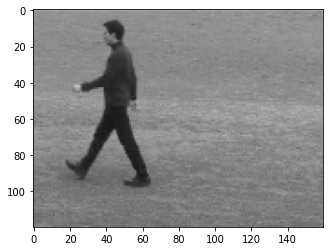

In [ ]:
videodata = skvideo.io.vread(DATASET[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

In [ ]:
CLASSES[DATASET[0][1]]

'walking'

## Визуализация "движения"

motion shape: (554, 120, 160, 1)
walking


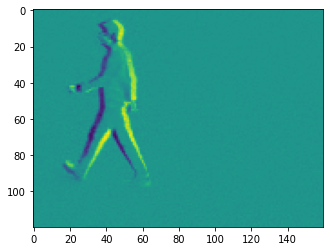

In [ ]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])
print(CLASSES[DATASET[0][1]])

Есть идея засунуть весь датасет да еще и с батчами, но это может сожрать память.     
Посмотрим, как сокращение количества кадров влияет накартинку

motion_red shape: (138, 120, 160, 1)


'walking'

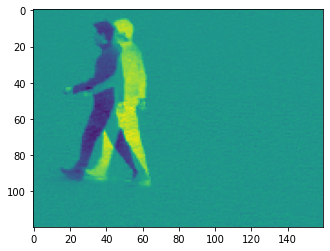

In [ ]:
reduction = 4
inds = list(range(0, videodata.shape[0], reduction))
videodata_red = videodata[inds, ...]
motion_red = np.mean(videodata_red[1:, ...] - videodata_red[:-1, ...], axis=3, keepdims=True)
print('motion_red shape:', motion_red.shape)
plt.imshow(motion_red[12, ..., 0])
CLASSES[DATASET[0][1]]

## Создание датасетов

Посмотрим, что мы имеем:

In [ ]:
DATASET[0][0]

'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/walking/person01_walking_d1_uncomp.avi'

In [ ]:
DATASET[0][1]

0

In [ ]:
CLASSES[DATASET[0][1]]

'walking'

In [ ]:
dataset_p = DATASET.copy()

In [ ]:
random.shuffle(dataset_p)
split = int(len(dataset_p) * 0.7)
train_dataset_p, val_dataset_p = dataset_p[:split], dataset_p[split:]

In [ ]:
print(len(train_dataset_p), train_dataset_p[0])
print(len(val_dataset_p), val_dataset_p[0])

419 ('/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/walking/person14_walking_d2_uncomp.avi', 0)
180 ('/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/handclapping/person01_handclapping_d3_uncomp.avi', 5)


In [ ]:
class Action_Dataset():

    def __init__(self, paths_dataset, reduction=1):
        self.reduction = reduction
        random.shuffle(paths_dataset)
        self.paths_dataset = paths_dataset

    def read_motion_and_class(self, path, cls):
        path = str(path)[2:-1]  # Избавляемся от "b'"
        videodata = skvideo.io.vread(path)
        videodata = videodata.astype(np.float32) / 255.
        
        inds = list(range(0, videodata.shape[0], self.reduction))
        videodata_red = videodata[inds, ...]
        motion_red = np.mean(videodata_red[1:, ...] - videodata_red[:-1, ...], axis=3, keepdims=True)
        
        return motion_red, cls

    def train_dataset(self, batch_size, epochs):

        dataset = tf.data.Dataset.from_generator(lambda: self.paths_dataset, (tf.string, tf.int32))
        dataset = dataset.map(lambda x_str, x_int: self.read_motion_and_class(x_str, x_int))
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size):

        dataset = tf.data.Dataset.from_generator(lambda: self.paths_dataset, ( tf.string, tf.int32))
        dataset = dataset.map(lambda x_str, x_int: self.read_motion_and_class(x_str, x_int))
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [ ]:
NUM_EPOCHS = 10

In [ ]:
AD = Action_Dataset(train_dataset_p, reduction=2)

In [ ]:
print(type(AD.paths_dataset))
print(len(AD.paths_dataset))
print(AD.paths_dataset[:2])

<class 'list'>
419
[('/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/handclapping/person23_handclapping_d2_uncomp.avi', 5), ('/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/jogging/person18_jogging_d4_uncomp.avi', 1)]


In [ ]:
AD.train_dataset(2, 2)

In [ ]:
ds = tf.data.Dataset.from_generator(
    lambda: AD.paths_dataset[:5], (tf.string, tf.int32))

In [ ]:
ds = ds.shuffle(buffer_size=len(AD.paths_dataset[:5]))

In [ ]:
def prs(x, y):
  tf.keras.backend.get_value(x)
  print(x, y)
  return x, y*20

In [ ]:
ds.map(lambda x, y: prs(x, y))

In [ ]:
dds = ds.map(lambda s, i: tf.py_function(prs, [s, i], (tf.string, tf.int32)))

In [ ]:
list(dds.as_numpy_iterator())

tf.Tensor(b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/jogging/person18_jogging_d4_uncomp.avi', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/handclapping/person23_handclapping_d2_uncomp.avi', shape=(), dtype=string) tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/walking/person16_walking_d3_uncomp.avi', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/walking/person03_walking_d2_uncomp.avi', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/running/person04_running_d2_uncomp.avi', shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int32)


[(b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/jogging/person18_jogging_d4_uncomp.avi',
  20),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/handclapping/person23_handclapping_d2_uncomp.avi',
  100),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/walking/person16_walking_d3_uncomp.avi',
  0),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/walking/person03_walking_d2_uncomp.avi',
  0),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/running/person04_running_d2_uncomp.avi',
  40)]

In [ ]:
dds

<MapDataset shapes: (<unknown>, <unknown>), types: (tf.string, tf.int32)>

In [ ]:
list(dds.as_numpy_iterator())

[(b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/walking/person23_walking_d2_uncomp.avi',
  0),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/handwaving/person11_handwaving_d3_uncomp.avi',
  80),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/jogging/person22_jogging_d3_uncomp.avi',
  20),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/boxing/person22_boxing_d1_uncomp.avi',
  60),
 (b'/content/gdrive/My Drive/AI/GB/CV/Lesson7/data/handwaving/person10_handwaving_d4_uncomp.avi',
  80)]

In [ ]:
elements = [(1, "foo"), (2, "bar"), (3, "baz")]
dataset = tf.data.Dataset.from_generator(
    lambda: elements, (tf.int32, tf.string))
# `map_func` takes two arguments of type `tf.Tensor`. This function
# projects out just the first component.
result = dataset.map(lambda x_int, y_str: x_int)
list(result.as_numpy_iterator())

[1, 2, 3]

In [ ]:
train_dataset = Action_Dataset(train_dataset_p, reduction=2).train_dataset(batch_size=2, epochs=NUM_EPOCHS)

In [ ]:
val_dataset = Action_Dataset(val_dataset_p, reduction=2).val_dataset(batch_size=2)

## Создание модели CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [ ]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 389, 120, 160, 1)
Output shape: (1, 6)


## Подготовка к обучению

In [ ]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

## Цикл обучения модели

In [ ]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/180] Loss = 1.7911447286605835
[0/10][10/180] Loss = 1.8088587522506714
[0/10][20/180] Loss = 1.7815322875976562
[0/10][30/180] Loss = 1.8034265041351318
[0/10][40/180] Loss = 1.7663718461990356
[0/10][50/180] Loss = 1.803052544593811
[0/10][60/180] Loss = 1.7825956344604492
[0/10][70/180] Loss = 1.7856658697128296
[0/10][80/180] Loss = 1.7887665033340454
[0/10][90/180] Loss = 1.7659820318222046
[0/10][100/180] Loss = 1.830854892730713
[0/10][110/180] Loss = 1.811326026916504
[0/10][120/180] Loss = 1.819488525390625
[0/10][130/180] Loss = 1.852985143661499
[0/10][140/180] Loss = 1.8686461448669434
[0/10][150/180] Loss = 1.7389452457427979
[0/10][160/180] Loss = 1.5842989683151245
[0/10][170/180] Loss = 1.5687462091445923
[1/10][0/180] Loss = 1.3859108686447144
[1/10][10/180] Loss = 1.299546241760254
[1/10][20/180] Loss = 1.2612519264221191
[1/10][30/180] Loss = 1.7985728979110718
[1/10][40/180] Loss = 1.7596839666366577
[1/10][50/180] Loss = 1.031031847000122
[1/10][60/180] Lo

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Тестирование обученной модели

True class: jogging
Predicted class: jogging


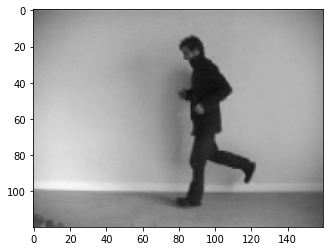

In [ ]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])